In [1]:
# forecast monthly births with xgboost
from numpy import asarray
import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error
import xgboost as xgb
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

C:\Users\eacun\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
import pandas as pd
from sklearn.multioutput import MultiOutputRegressor
import numpy as np
import xml.etree.cElementTree as et
from datetime import datetime
from pandas.core.tools.datetimes import to_datetime
from datetime import timedelta

In [3]:
# get some noised linear data
# X = np.random.random((1000, 10))
#a = np.random.random((10, 3))
#y = np.dot(X, a) + np.random.normal(0, 1e-3, (1000, 3))
#print(y.shape)
# fitting
#multioutputregressor = MultiOutputRegressor(xgb.XGBRegressor(objective='reg:squarederror')).fit(X, y)

# predicting
#print(np.mean((multioutputregressor.predict(X) - y)**2, axis=0))  # 0.004, 0.003, 0.005

In [4]:
def read_xml_data(filename, selected_items):
  tree=et.parse(filename)
  root=tree.getroot()
  #extract selected items
  for child in root:
    if child.tag in selected_items:
      df = pd.DataFrame()
      for elem in child:      
        df1 = pd.DataFrame(elem.attrib, index=[0])
        #df = df.append(df1)d
        df = pd.concat([df, df1])
      #First column is the timestamp (dayfirst)      
      #df.iloc[:,0] = pd.to_datetime(df.iloc[:,0], dayfirst=True)
      #write to csv file using the timestamp as index      
      df.to_csv(child.tag+'.csv', index=0)  

In [5]:
def read_ts_file(filename):
  #reads csv file where the first column is a timestamp and the index column
  df = pd.read_csv (filename, parse_dates=[0], dayfirst=True, index_col=0)
  return df

In [6]:
def align_timeseries(align_df, source_df, source_columns, default_vals, dest_columns=[], include_index=False):
  # Generates a new dataframe with source_df data aligned to align_df
  # source_columns : list of columns from source_df to be included in result
  # dest_columns = column names of source_columns, if ommited column names will be the same as in source_df
  #                if specified, the first column has to be the name of the index in the destination
  # include_index: if source index must be included in the result
  # default_vals = list of default values for source_columns
 
  df_align = align_df.copy()
  df_align = df_align.sort_index()
  df2 = source_df.copy()
  df2 = df2.sort_index()
  df_dup = pd.DataFrame()
  if (dest_columns==[]) : dest_columns = source_columns.copy()
  if (len(dest_columns) == len(source_columns)) : dest_columns = ['source_ts'] + dest_columns # add column for index
  #add blank cells in destination
  df_align[dest_columns] = [np.nan] + default_vals
  for i in range(len(df2)):
      ts2 = df2.index[i]
      ts1_loc = df_align.index.get_loc(ts2, method='nearest')
      ts1 = df_align.index[ts1_loc]
      vals = [ts2]+list(df2.loc[ts2, source_columns])
      ts_old = df_align.loc[ts1, dest_columns[0]]
      if not pd.isna(ts_old): #there are duplicates
        if (abs(ts1.value-ts2.value) > abs(ts1.value-ts_old.value)): 
          #difference is greater, do not replace        
          df_dup = df_dup.append(df_align.loc[ts1])
          df_dup.loc[ts1, dest_columns] = vals
        else: #replace
          df_dup = df_dup.append(df_align.loc[ts1])
          df_align.loc[ts1, dest_columns] = vals
        continue
      df_align.loc[ts1, dest_columns] = vals
  
  if not(include_index) : df_align = df_align.drop( columns = dest_columns[0])

  return df_align, df_dup

In [7]:
def timedf(df):
  #creates a 5 minute interval timeseries dataframe based in index of df
  # df must have a timestamp index
  #time_df: result dataframe with timestamp index
  timestamp = pd.date_range(start=df.index[0], end=df.index[-1]  + timedelta(minutes=4), freq='5T')
  time_df = pd.DataFrame({'timestamp':timestamp})
  time_df.set_index('timestamp', inplace=True)
  return time_df

In [8]:
def find_gaps(df, greaterthan=5, units='m'):
  # find gaps relative to index, index must be a datetime field
  # greaterthan is the number of time units to be considered a gap
  # units 'm'=minutes, 'h'=hours
  i = 0
  gaps_df = pd.DataFrame()
  while i < len(df) - 1:
    ts = df.index[i]
    next_ts = df.index[i+1]
    duration = next_ts - ts
    if duration > np.timedelta64(greaterthan, units): 
      begin_gap = ts
      end_gap = next_ts
      gaps_df = gaps_df.append({'From': begin_gap, 'To': end_gap, 'Duration': duration}, ignore_index=True)
    i = i + 1
  gaps_df.sort_values(by=['Duration'], ascending=False, inplace=True)
  return gaps_df

In [9]:
def read_files():
  #read glucose
  glucose_df = read_ts_file('glucose_level.csv')
  glucose_df.rename(columns={"ts": "timestamp", "value": "glucose"}, inplace=True)
  print(glucose_df)
  #read meal
  meal_df = read_ts_file('meal.csv')
  print(meal_df)
  #read bolus
  meal_df = read_ts_file('bolus.csv')
  print(meal_df)

## Reading Training Data

In [10]:
#selected_items = ['glucose_level','bolus','meal']
read_xml_data(filename='c://aadm/588-ws-training.xml', selected_items=['glucose_level','bolus','meal'])

In [11]:
glucose_train = read_ts_file('glucose_level.csv')
glucose_train.rename(columns={"ts": "timestamp", "value": "glucose"}, inplace=True)
glucose_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12640 entries, 2021-08-30 11:53:00 to 2021-10-14 23:55:00
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   glucose  12640 non-null  int64
dtypes: int64(1)
memory usage: 197.5 KB


In [12]:
#Finding the length of the complete time series
time_df = timedf(glucose_train)
print('Missing intervals: ', len(time_df) - len(glucose_train) )

Missing intervals:  466


In [13]:
#Adding NA in the whole range of cgm-training
cgmtrainmiss=glucose_train.resample('5T').mean()
cgmtrainmiss.info()
cgmoriginal=cgmtrainmiss
dftso=cgmoriginal['2021-08-31 00:00:00':'2021-09-06 23:59:00']
dftso

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13106 entries, 2021-08-30 11:50:00 to 2021-10-14 23:55:00
Freq: 5T
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   glucose  12640 non-null  float64
dtypes: float64(1)
memory usage: 204.8 KB


,glucose
ts,
2021-08-31 00:00:00,99.0
2021-08-31 00:05:00,99.0
2021-08-31 00:10:00,98.0
2021-08-31 00:15:00,99.0
2021-08-31 00:20:00,100.0
...,...
2021-09-06 23:35:00,143.0
2021-09-06 23:40:00,142.0
2021-09-06 23:45:00,140.0


In [14]:
def impute_mean(df, column, by='hour'):
  # impute with mean by hours
  # in the future by could be another mean grouping criterion
  df[by] = df.index.hour
  df[column] = df.groupby(by)[column].apply(lambda x: x.fillna(x.mean()))
  df.drop(by, axis=1, inplace=True)

In [15]:
#def impute_mean(df, column,by="hour"):
# impute with mean by hours
#df[by] = df.index.hour
#df[by] = ['{}:{:02d}'.format(r.hour, (r.minute//10)*10) for r in df.index]
#print(df)
#df[column] = df.groupby(by)[column].apply(lambda x: x.fillna(x.aggregate(np.mean)))
#df.drop(by, axis=1, inplace=True)
#impute_mean(cgmtrainmiss, 'glucose')
#cgmtrainclean=cgmtrainmiss
#cgmtrainclean.describe()

In [16]:
#def impute_meandw(df, column):
#     df[column] = (df.groupby((df.index.dayofweek * 24) + (df.index.hour) + (df.index.minute //5)*5).transform(lambda x: x.fillna(x.mean())))
#impute_meandw(cgmtrainmiss, 'glucose')
#cgmtrainclean=cgmtrainmiss
#cgmtrainclean.info()

In [17]:
cgmtrainclean= cgmtrainmiss.interpolate(method="polynomial",order=3)
#cgmtrainclean.describe()

In [18]:
#import rpy2
#import rpy2.rinterface
#%load_ext rpy2.ipython
#import rpy2.robjects as robjects
#3from rpy2.robjects.packages import importr
#splines = importr('splines') 
#x_train=np.arange(len(cgmtrainclean))
#y_train=cgmtrainclean['glucose']
#r_y = robjects.FloatVector(y_train)
#r_x = robjects.FloatVector(x_train)
#r_smooth_spline = robjects.r['smooth.spline'] #extract R function# run smoothing function
#spline1 = r_smooth_spline(x=r_x,y=r_y, spar=.1)
#ySpline=np.array(robjects.r['predict'](spline1,robjects.FloatVector(x_train)).rx2('y'))
#print(ySpline)
#plt.figure(figsize=(12,6))
#plt.scatter(x_train,y_train,c="blue")
#plt.plot(x_train,ySpline,c='red')

In [19]:
#Imputation using Kalman smoothing and spline smoothing
from tsmoothie.smoother import *
from tsmoothie.utils_func import create_windows
#smoother1 = SplineSmoother(n_knots=1500,spline_type='cubic_spline')
#smoother1.smooth(cgmtrainclean[['glucose']].T)
#smoother1 = KalmanSmoother(component='level_season', 
#component_noise={'level':0.1, 'season':0.1},n_seasons=7)
#smoother1.smooth(cgmtrainmiss[['glucose']].T)
#glucosekf=smoother1.smooth_data[0]
#cgmtrainclean=cgmtrainmiss
#cgmtrainclean['glucose']=glucosekf
#cgmtrainclean['glucose']=ySpline
cgmtrainclean.describe()

,glucose
count,13106.000000
mean,153.513786
std,129.439439
min,-1524.727286
25%,127.000000
50%,159.000000
75%,199.000000
max,400.000000


In [20]:
#a=cgmtrainclean['glucose']-cgmtrainmiss['glucose']
#a.describe()

In [21]:
dftsw=cgmtrainclean['2021-08-31 00:00:00':'2021-09-06 23:59:00']
dftsw.head(50)

,glucose
ts,
2021-08-31 00:00:00,99.0
2021-08-31 00:05:00,99.0
2021-08-31 00:10:00,98.0
2021-08-31 00:15:00,99.0
2021-08-31 00:20:00,100.0
2021-08-31 00:25:00,101.0
2021-08-31 00:30:00,102.0
2021-08-31 00:35:00,102.0
2021-08-31 00:40:00,101.0


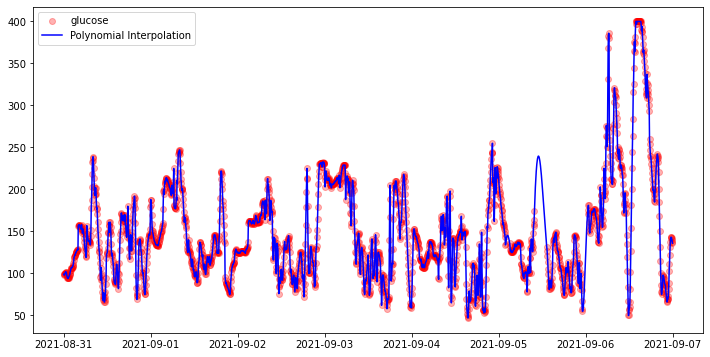

In [22]:
plt.figure(figsize=(12,6))
plt.scatter(dftso.index,dftso['glucose'],c='red', label='glucose', alpha=0.3)
plt.plot(dftso.index,dftsw['glucose'],c='blue',label='Polynomial Interpolation')
plt.legend()

## Reading the testing data

In [23]:
#selected_items = ['glucose_level','bolus','meal']
read_xml_data(filename='c://aadm/563-ws-testing.xml', selected_items=['glucose_level','bolus','meal'])

In [24]:
glucose_test = read_ts_file('glucose_level.csv')
glucose_test.rename(columns={"ts": "timestamp", "value": "glucose"}, inplace=True)
glucose_test.describe()

,glucose
count,2570.000000
mean,167.372374
std,46.138496
min,62.000000
25%,134.000000
50%,167.000000
75%,195.000000
max,313.000000


In [25]:
#Finding the length of the complete time series
time_df = timedf(glucose_test)
print('Missing intervals: ', len(time_df) - len(glucose_test) )

Missing intervals:  122


In [26]:
# All gaps 
gaps_df = find_gaps(glucose_test)
#print(gaps_df)

C:\Users\eacun\AppData\Local\Temp\ipykernel_10216\1628313578.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gaps_df = gaps_df.append({'From': begin_gap, 'To': end_gap, 'Duration': duration}, ignore_index=True)
C:\Users\eacun\AppData\Local\Temp\ipykernel_10216\1628313578.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gaps_df = gaps_df.append({'From': begin_gap, 'To': end_gap, 'Duration': duration}, ignore_index=True)
C:\Users\eacun\AppData\Local\Temp\ipykernel_10216\1628313578.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gaps_df = gaps_df.append({'From': begin_gap, 'To': end_gap, 'Duration': duration}, ignore_index=True)


In [27]:
#Adding NA in the whole range of cgm-testing
cgmtestmiss=glucose_test.resample('5T').mean()
#cgmtestmiss.describe()

In [28]:
impute_mean(cgmtestmiss, 'glucose')
cgmtestclean=cgmtestmiss
cgmtestclean.describe()

,glucose
count,2691.000000
mean,167.346194
std,45.125898
min,62.000000
25%,136.000000
50%,166.000000
75%,194.000000
max,313.000000


In [29]:
#cgmtestclean= cgmtestmiss.interpolate(method="quadratic")
#cgmtestclean.describe()

Unable to determine R home: [WinError 2] The system cannot find the file specified
C:\Users\eacun\anaconda3\lib\site-packages\rpy2\robjects\packages.py:367: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(


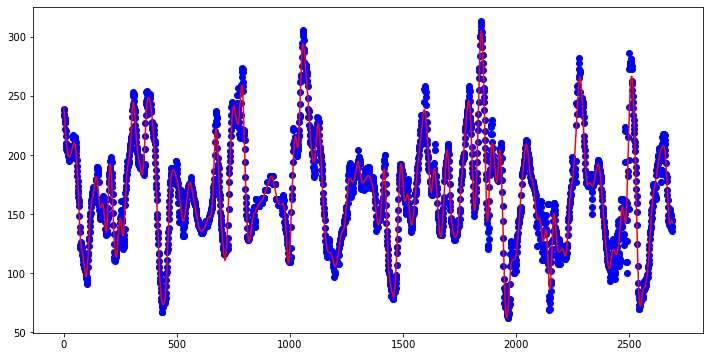

In [30]:
import rpy2
import rpy2.rinterface
%load_ext rpy2.ipython
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
splines = importr('splines') 
x_train=np.arange(len(cgmtestclean))
y_train=cgmtestclean['glucose']
r_y = robjects.FloatVector(y_train)
r_x = robjects.FloatVector(x_train)
r_smooth_spline = robjects.r['smooth.spline'] #extract R function# run smoothing function
spline1 = r_smooth_spline(x=r_x,y=r_y, spar= .1)
ySpline=np.array(robjects.r['predict'](spline1,robjects.FloatVector(x_train)).rx2('y'))
#print(ySpline)
plt.figure(figsize=(12,6))
plt.scatter(x_train,y_train,c="blue")
plt.plot(x_train,ySpline,c='red')

In [31]:
#Imputation using Kalman smoothing or smoothing spline
#Imputation using Kalman Filter
from tsmoothie.smoother import *
from tsmoothie.utils_func import create_windows
#smoother1 = SplineSmoother(n_knots=1500, spline_type='cubic_spline')
#smoother1.smooth(cgmtestclean[['glucose']].T)
#smoother = KalmanSmoother(component='level_season', 
#                          component_noise={'level':0.1, 'season':0.1},n_seasons=7)
#smoother.smooth(cgmtrainmiss[['glucose']].T)
#glucosekf=smoother1.smooth_data[0]
#cgmtestclean=cgmtestnmiss
#cgmtestclean['glucose']=glucosekf
#smoother1.smooth_data[0].mean()
#smoother1 = SplineSmoother(n_knots=400, spline_type='linear_spline')
#smoother1.smooth(cgmtestclean[['glucose']].T)
#smoother.smooth(cgmtrainmiss[['glucose']].T)
#glucosekf=smoother.smooth_data[0]
#cgmtrainclean=cgmtrainmiss
#cgmtrainclean['glucose']=glucosekf
cgmtestclean['glucose']=ySpline
cgmtestclean.describe()

,glucose
count,2691.000000
mean,167.346194
std,43.962888
min,62.069281
25%,137.090382
50%,166.383143
75%,193.721314
max,305.037669


In [32]:
#Normalizing the data
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
datatrain = np.array(cgmtrainclean.values.astype('float32'))
datatest = np.array(cgmtestclean.values.astype('float32'))
#scaler = MinMaxScaler(feature_range=(0, 1))
#datatrain = scaler.fit_transform(datatrain).flatten()
#datatest = scaler.fit_transform(datatest).flatten()
#n = len(data)
train_data=pd.DataFrame(datatrain)
test_data=pd.DataFrame(datatest)

In [33]:
print(train_data.shape)
print(test_data.shape)

(13106, 1)
(2691, 1)


In [34]:
# convert time series into supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars=1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [35]:
#Past history: One hour, Prediction horizon: 30 minutes 
n_lag=12
n_seq=6

In [36]:
data1=series_to_supervised(train_data, n_in=n_lag, n_out=n_seq, dropnan=True)
data2=series_to_supervised(test_data, n_in=n_lag, n_out=n_seq, dropnan=True)
train=data1.values
test=data2.values
#print(data1.shape)
print("test shape:",test.shape)
print("train shape:",train.shape)

test shape: (2674, 18)
train shape: (13089, 18)


In [37]:
# transform list into array
#train = asarray(train)
# split into input and output columns
X, y = train[:, 0:n_lag], train[:, n_lag:]
print(y.shape)
# fit model
import time
start_time = time.time()
#model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
multioutputregressor = MultiOutputRegressor(xgb.XGBRegressor(objective='reg:squarederror',n_estimators=1000)).fit(X, y)
# predicting
a=multioutputregressor.predict(X)-y
a=DataFrame(a)
a.head()

(13089, 6)


,0,1,2,3,4,5
0,0.203796,-0.955826,-1.076965,-0.891434,0.419540,-0.844315
1,-0.271912,-0.409317,-1.219925,-0.177704,0.001785,-1.494980
2,0.145798,-0.325333,-0.506363,0.322510,-0.198013,-0.708939
3,0.180847,0.302536,-0.112900,-0.234650,-0.658661,0.838821
4,-0.158081,-0.476868,-0.143433,-0.648468,-0.659546,-1.757111


In [38]:
testX, testy = test[:,0:n_lag], test[:, n_lag:]

In [39]:
b = np.sqrt(np.mean((multioutputregressor.predict(testX)-testy)**2,axis=0))
from math import sqrt
b=DataFrame(b)
#b.head()
b.mean()

0    7.156105
dtype: float32

In [40]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 28.47899293899536 seconds ---
